In this notebook I compute the curves ilustrating input alignment and control transfer in the two-pathway model.

This code may be reused or adapted, in which case please cite the following paper:

"Remembrance of things practiced: Fast and slow learning in cortical and subcortical circuits,"
James M. Murray and G. Sean Escola (Nature Communications, 2020).

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

# Alignment increases as training is repeated for a single pattern

In [4]:
def theta(h):
    return 0.5*(1 + np.sign(h))

def sigmoid(h):
    return 1/(1 + np.exp(-h))

def alignment_singlepattern(nx, ny, n_reps, RL=0, etaRL=1, nz=1, alpha=1, beta=1, w0=1.71):
    '''
    Given the number of units in each input population , the number of patterns to be
    learned sequentially, and the number of times to repeat training of each pattern, train a
    single network and return a binary array, where each element is 0 if the corresponding
    pattern was recalled correctly during testing, or 1 if incorrect.
    
    Parameters
    ----------
    nx, ny : The numbers of units in the two input layers (x~supervised learning, y~Hebbian learning).
        
    n_reps : An array of length p specifying the number of repetitions when training each pattern.
    
    RL : If 0, use supervised learning in the first pathway. If 1, use reinforcement learning in the
        first pathway and Hebbian learning in the second. If 2, use RL in both pathways.
    
    etaRL : If RL is nonzero, the learning rate used for reinforcement learning. If RL is 2, etaRL
        may be a list of learning rates to use in each pathway.
    
    nz : Number of output units.
    
    alpha : Controls the decay rate of Hebbian weights.
    
    beta : Controls the learning rate for the Hebbian weights.

    w0 : The initial magnitude of the weight vector undergoing supervised learning.

    Returns
    -------  
    alignment : An array of length n_reps, where each element gives the normalized alignment of
        the inputs from the two pathways for that pattern.
        
    hfrac : The fraction of input along the readout direction that comes from the student input.
    
    p_correct : The fraction of readout units that correctly aligns with the target readout
        state.
        
    p_correct : The fraction of correct readout units when the input from the first pathway
        is turned off.
    '''
    n_bar = np.mean(n_reps)
    v0 = beta/alpha**0.5
    tau_rew = 10
    rbar = 0
        
    x = np.random.randn(nx)
    y = np.random.randn(ny)
    z_ = np.random.choice([-1, 1], (nz))
    w = w0*np.random.randn(nz, nx)/nx**0.5
    v = v0*np.random.randn(nz, ny)/ny**0.5
    alignment = np.zeros(n_reps)
    hfrac = np.zeros(n_reps)
    p_correct = np.zeros(n_reps)
    p_correct_honly = np.zeros(n_reps)
    
    if type(etaRL)==list:
        [eta1, eta2] = etaRL
    else:
        eta1 = etaRL
        
    for ii in range(n_reps):
        m = np.dot(w, x)
        h = np.dot(v, y)

        alignment[ii] = np.dot(m/np.linalg.norm(m), h/np.linalg.norm(h))
        hfrac[ii] = abs(np.dot(h, z_))/(abs(np.dot(h, z_)) + abs(np.dot(m, z_)))

        if RL!=0:  # RL in first pathway
            # z[ii]=1 with probability sigmoid(m+h)[ii], or else -1:
            z = 2*(np.random.rand(nz) < sigmoid(m + h)) - 1
            rew = np.dot(z, z_)/nz**0.5
            rbar = (1-1/tau_rew)*rbar + rew/tau_rew
            dw = eta1*np.outer((rew-rbar)*z*sigmoid(-z*(m+h)), x)/nx
        else:
            dw = np.outer((z_ - m - h)*theta(1 - (m + h)*z_), x)/nx        
            z = z_  # supervised learning realizes the correct output in one step
        w += dw
        z_honly = 2*(np.random.rand(nz) < sigmoid(h)) - 1
        
        if RL==2:  # RL in second pathway
            dv = eta2*np.outer((rew-rbar)*z*sigmoid(-z*(m+h)), y)/ny
        else:
            dv = 2**0.5*beta*np.outer(z, y)/ny
            dv += -alpha*v/ny
        v += dv

        p_correct[ii] = 0.5*(1 + np.dot(z, z_)/nz)
        p_correct_honly[ii] = 0.5*(1 + np.dot(z_honly, z_)/nz)
                    
    return alignment, hfrac, p_correct, p_correct_honly


In [5]:
n_reps = 11
n_nets = 1000

alignment = np.zeros((n_nets, n_reps))
hfrac = np.zeros((n_nets, n_reps))
for ii in range(n_nets):
    alignment[ii,:], hfrac[ii,:], _, _ = alignment_singlepattern(1000, 1000, n_reps, nz=1000)


<IPython.core.display.Javascript object>


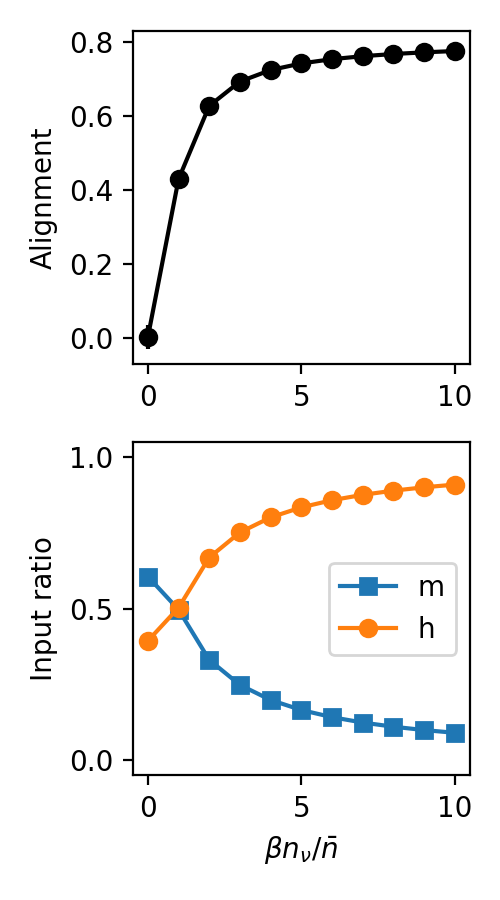

In [6]:
plt.figure(figsize=(2.5, 4.5))

plt.subplot(211)
plt.errorbar(np.arange(n_reps), np.mean(alignment, axis=0), yerr=np.std(alignment, axis=0), 
             color='k', ls='-', marker='o')
plt.ylabel('Alignment')

plt.subplot(212)
plt.plot(np.arange(n_reps), 1 - np.mean(hfrac, axis=0), ls='-', marker='s')
plt.plot(np.arange(n_reps), np.mean(hfrac, axis=0), ls='-', marker='o')

plt.xlabel('$\\beta n_\\nu / \\bar{n}$')
plt.ylabel('Input ratio')
plt.ylim(-0.05,1.05)
plt.yticks([0, 0.5, 1])
plt.legend(['m', 'h'])

plt.tight_layout()

## Alignment and input ratio with RL+HL

Now use reinforcement learning rather than supervised learning in the first pathway.

In [7]:
n_reps = 1001
n_nets = 100
eta = 1
beta = 0.01

alignmentRL = np.zeros((n_nets, n_reps))
hfracRL = np.zeros((n_nets, n_reps))
p_correctRL = np.zeros((n_nets, n_reps))
p_correct_honlyRL = np.zeros((n_nets, n_reps))
for jj in range(n_nets):
    foo = alignment_singlepattern(1000, 1000, n_reps, RL=1, etaRL=eta, nz=10, beta=beta)
    alignmentRL[jj,:] = foo[0]
    hfracRL[jj,:] = foo[1]
    p_correctRL[jj,:] = foo[2]
    p_correct_honlyRL[jj,:] = foo[3]

<IPython.core.display.Javascript object>


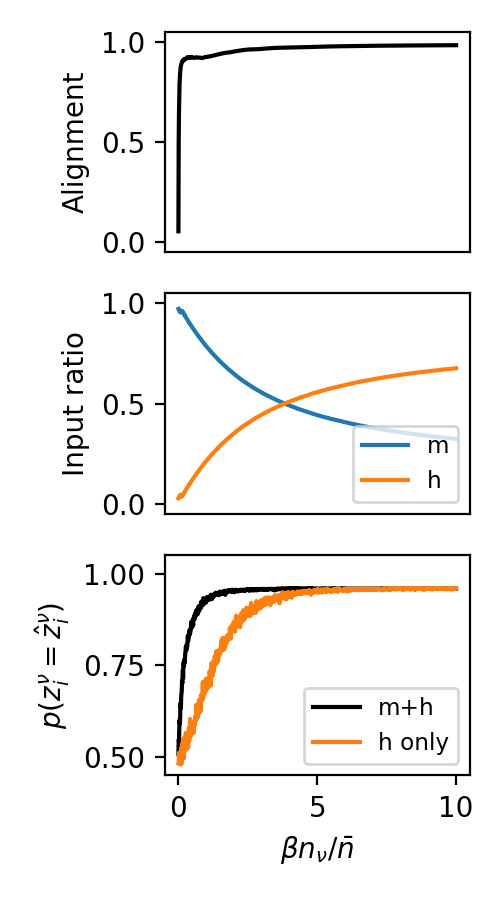

In [8]:
plt.figure(figsize=(2.5, 4.5))

plt.subplot(311)
plt.plot(beta*np.arange(n_reps), np.mean(alignmentRL, axis=0),
         color='k', ls='-')
plt.ylabel('Alignment')
plt.ylim(-0.05,1.05)
plt.xticks([])

plt.subplot(312)
plt.plot(beta*np.arange(n_reps), 1 - np.mean(hfracRL, axis=0), 
         color='tab:blue', ls='-')
plt.plot(beta*np.arange(n_reps), np.mean(hfracRL, axis=0), 
         color='tab:orange', ls='-')

plt.ylabel('Input ratio')
plt.ylim(-0.05,1.05)
plt.yticks([0, 0.5, 1])
plt.legend(['m', 'h'], loc=4, fontsize='small')
plt.xticks([])

plt.subplot(313)
plt.plot(beta*np.arange(n_reps), np.mean(p_correctRL, axis=0),
         color='k', ls='-')
plt.plot(beta*np.arange(n_reps), np.mean(p_correct_honlyRL, axis=0),
         color='tab:orange', ls='-')
plt.xlabel('$\\beta n_\\nu / \\bar{n}$')
plt.legend(['m+h', 'h only'], fontsize='small')
plt.ylabel('$p(z_i^\\nu = \hat{z}_i^\\nu)$')
plt.ylim(0.45, 1.05)

plt.tight_layout()

## Alignment and input ratio with RL+RL

As a control, look at input alignment and control transfer in a model with RL in both pathways.

In [9]:
n_reps = 1001
n_nets = 100
eta = [1, 0.01]
beta = 1

alignmentRL2 = np.zeros((n_nets, n_reps))
hfracRL2 = np.zeros((n_nets, n_reps))
p_correctRL2 = np.zeros((n_nets, n_reps))
p_correct_honlyRL2 = np.zeros((n_nets, n_reps))
for jj in range(n_nets):
    foo = alignment_singlepattern(1000, 1000, n_reps, RL=2, etaRL=eta, nz=10, beta=beta)
    alignmentRL2[jj,:] = foo[0]
    hfracRL2[jj,:] = foo[1]
    p_correctRL2[jj,:] = foo[2]
    p_correct_honlyRL2[jj,:] = foo[3]

<IPython.core.display.Javascript object>


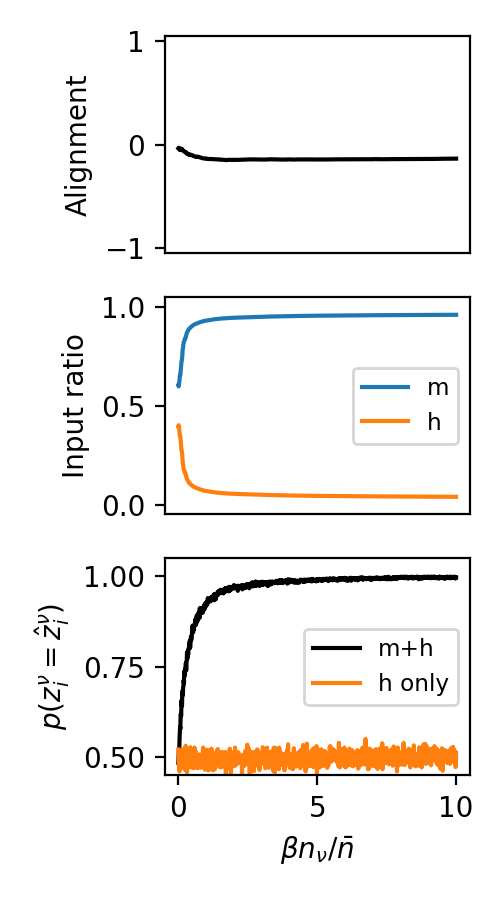

In [10]:
plt.figure(figsize=(2.5, 4.5))

plt.subplot(311)
plt.plot(beta*np.arange(n_reps), np.mean(alignmentRL2, axis=0),
         color='k', ls='-')
plt.ylabel('Alignment')
plt.ylim(-1.05,1.05)
plt.xticks([])

plt.subplot(312)
plt.plot(beta*np.arange(n_reps), 1 - np.mean(hfracRL2, axis=0), 
         color='tab:blue', ls='-')
plt.plot(beta*np.arange(n_reps), np.mean(hfracRL2, axis=0), 
         color='tab:orange', ls='-')

plt.ylabel('Input ratio')
plt.ylim(-0.05,1.05)
plt.yticks([0, 0.5, 1])
plt.legend(['m', 'h'], fontsize='small')
plt.xticks([])

plt.subplot(313)
plt.plot(beta*np.arange(n_reps), np.mean(p_correctRL2, axis=0),
         color='k', ls='-')
plt.plot(beta*np.arange(n_reps), np.mean(p_correct_honlyRL2, axis=0),
         color='tab:orange', ls='-')
plt.xlabel('$\\beta n_\\nu / \\bar{n}$')
plt.legend(['m+h', 'h only'], fontsize='small')
plt.ylabel('$p(z_i^\\nu = \hat{z}_i^\\nu)$')
plt.ylim(0.45, 1.05)
plt.xticks([0, (n_reps-1)/2, n_reps-1], [0, int(0.01*(n_reps-1)/2), int(0.01*(n_reps-1))])

plt.tight_layout()

# Alignment with two successive patterns with RL

If the same input is remapped to a new pattern, see how successful learning of the second pattern is either with or with out the slow-learning pathway.

In [12]:
def alignment_twopatterns(nx, ny, n_reps, nswitch=0, etaRL=1, nz=1, alpha=1, beta=1, w0=1.71):
    '''
    Given the number of units in each input population , the number of patterns to be
    learned sequentially, and the number of times to repeat training of each pattern, train a
    single network and return a binary array, where each element is 0 if the corresponding
    pattern was recalled correctly during testing, or 1 if incorrect.
    
    Parameters
    ----------
    nx, ny : The numbers of units in the two input layers (x~supervised learning, y~Hebbian learning).
        
    n_reps : Number of times to repeat the pattern.
    
    nswitch : Number of repetitions after which to switch from learning the first output to 
        learning the second (given the same input).
        
    etaRL : If RL is nonzero, the learning rate used for reinforcement learning. If RL is 2, etaRL
        may be a list of learning rates to use in each pathway.
        
    nz : Number of output units.
    
    alpha : Controls the decay rate of Hebbian weights.
    
    beta : Controls the learning rate for the Hebbian weights.
            
    w0 : The initial magnitude of the weight vector undergoing supervised learning.

    Returns
    -------  
    alignment : An array of length n_reps, where each element gives the normalized alignment of
        the inputs from the two pathways for that pattern.
        
    hfrac : The fraction of input along the readout direction that comes from the student input.
    '''
    n_bar = np.mean(n_reps)
    v0 = beta/alpha**0.5
    tau_rew = 10
    rbar = 0
        
    x = np.random.randn(nx)
    y = np.random.randn(ny)
    z1_ = np.random.choice([-1, 1], (nz))
    z2_ = np.random.choice([-1, 1], (nz))
    w = w0*np.random.randn(nz, nx)/nx**0.5
    v = v0*np.random.randn(nz, ny)/ny**0.5
    p_correct1 = np.zeros(n_reps)
    p_correct2 = np.zeros(n_reps)
    p_correct1_honly = np.zeros(n_reps)
    p_correct2_honly = np.zeros(n_reps)
    rewards = np.zeros(n_reps)
    
    if type(etaRL)==list:
        [eta1, eta2] = etaRL
    else:
        eta1 = etaRL
        
    for ii in range(n_reps):
        m = np.dot(w, x)
        h = np.dot(v, y)

        # RL in first pathway
        # z[ii]=1 with probability sigmoid(m+h)[ii], or else -1:
        z = 2*(np.random.rand(nz) < sigmoid(m + h)) - 1
        z_honly = 2*(np.random.rand(nz) < sigmoid(h)) - 1

        # First learn pattern 1, then pattern 2:
        if ii < nswitch:
            rew = np.dot(z, z1_)/nz**0.5
        else:
            rew = np.dot(z, z2_)/nz**0.5
        rbar = (1-1/tau_rew)*rbar + rew/tau_rew
        dw = eta1*np.outer((rew-rbar)*z*sigmoid(-z*(m+h)), x)/nx
        w += dw
        
        dv = 2**0.5*beta*np.outer(z, y)/ny
        dv += -alpha*v/ny
        v += dv

        p_correct1[ii] = 0.5*(1 + np.dot(z, z1_)/nz)
        p_correct2[ii] = 0.5*(1 + np.dot(z, z2_)/nz)
        p_correct1_honly[ii] = 0.5*(1 + np.dot(z_honly, z1_)/nz)
        p_correct2_honly[ii] = 0.5*(1 + np.dot(z_honly, z2_)/nz)
        rewards[ii] = rew
                    
    return p_correct1, p_correct2, p_correct1_honly, p_correct2_honly, rewards


Switch to a new target output after `nswitch` repetitions, and see how learning of the second pattern compares either with or without the second pathway.

In [14]:
n_reps = 501
n_nets = 100
etaRL = 1
beta = 0.01
nswitch = 100

p_correct1_onepath = np.zeros((n_nets, n_reps))
p_correct2_onepath = np.zeros((n_nets, n_reps))
p_correct1_twopaths = np.zeros((n_nets, n_reps))
p_correct2_twopaths = np.zeros((n_nets, n_reps))

for jj in range(n_nets):
    foo_onepath = alignment_twopatterns(1000, 1000, n_reps, nswitch=nswitch, etaRL=etaRL, nz=10, beta=0)
    p_correct1_onepath[jj,:] = foo_onepath[0]
    p_correct2_onepath[jj,:] = foo_onepath[1]
    foo_twopaths = alignment_twopatterns(1000, 1000, n_reps, nswitch=nswitch, etaRL=etaRL, nz=10, beta=beta)
    p_correct1_twopaths[jj,:] = foo_twopaths[0]
    p_correct2_twopaths[jj,:] = foo_twopaths[1]


<IPython.core.display.Javascript object>


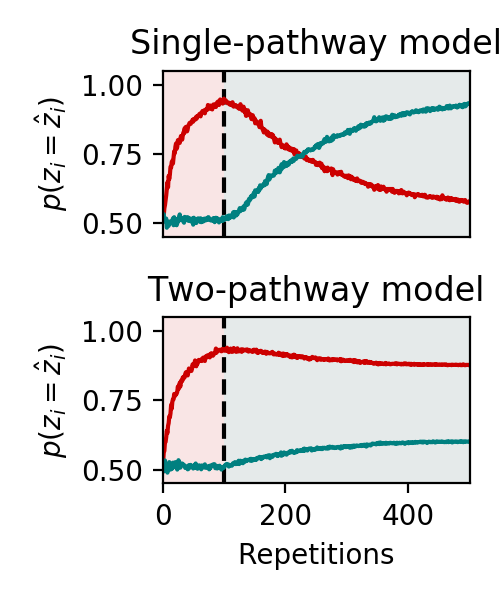

In [350]:
plt.figure(figsize=(2.5, 3))

plt.subplot(211)
plt.axvspan(0, nswitch, facecolor=(0.8,0,0), alpha=0.1)
plt.axvspan(nswitch, n_reps, facecolor=(0,0.2,0.2), alpha=0.1)
plt.plot(np.arange(n_reps), np.mean(p_correct1_onepath, axis=0), color=(0.8,0,0))
plt.plot(np.arange(n_reps), np.mean(p_correct2_onepath, axis=0), color=(0,0.5,0.5))
plt.vlines(nswitch, 0.45, 1.05, linestyles='dashed')
plt.xlim([0, n_reps])
plt.ylim(0.45, 1.05)
plt.xticks([])
plt.yticks([0.5, 0.75, 1.0])
plt.ylabel('$p(z_i = \hat{z}_i)$')
plt.title('Single-pathway model')

plt.subplot(212)
plt.axvspan(0, nswitch, facecolor=(0.8,0,0), alpha=0.1)
plt.axvspan(nswitch, n_reps, facecolor=(0,0.2,0.2), alpha=0.1)
plt.plot(np.arange(n_reps), np.mean(p_correct1_twopaths, axis=0), color=(0.8,0,0))
plt.plot(np.arange(n_reps), np.mean(p_correct2_twopaths, axis=0), color=(0,0.5,0.5))
plt.vlines(nswitch, 0.45, 1.05, linestyles='dashed')
plt.xlim([0, n_reps])
plt.ylim(0.45, 1.05)
plt.yticks([0.5, 0.75, 1.0])
plt.xlabel('Repetitions')
plt.ylabel('$p(z_i = \hat{z}_i)$')
plt.title('Two-pathway model')

plt.tight_layout()

In [344]:
n_reps = 501
n_nets = 1000
etaRL = 1
beta = 0.01
nswitch_list = 10*np.arange(11)
n_etas = len(etaRL_list)

p_correct1_onepath = np.zeros((len(nswitch_list), n_nets, n_reps))
p_correct2_onepath = np.zeros((len(nswitch_list), n_nets, n_reps))
p_correct1_twopaths = np.zeros((len(nswitch_list), n_nets, n_reps))
p_correct2_twopaths = np.zeros((len(nswitch_list), n_nets, n_reps))
n75_onepath = np.zeros(len(nswitch_list))
n75_twopaths = np.zeros(len(nswitch_list))

for ii, nswitch in enumerate(nswitch_list):
    for jj in range(n_nets):
        foo_onepath = alignment_twopatterns(1000, 1000, n_reps, nswitch=nswitch, etaRL=etaRL, nz=10, beta=0)
        p_correct1_onepath[ii,jj,:] = foo_onepath[0]
        p_correct2_onepath[ii,jj,:] = foo_onepath[1]
        foo_twopaths = alignment_twopatterns(1000, 1000, n_reps, nswitch=nswitch, etaRL=etaRL, nz=10, beta=beta)
        p_correct1_twopaths[ii,jj,:] = foo_twopaths[0]
        p_correct2_twopaths[ii,jj,:] = foo_twopaths[1]

    if np.min((np.mean(p_correct2_onepath[ii,:,:], axis=0) - 0.75)**2) < 1e-4:
        n75_onepath[ii] = np.argmin((np.mean(p_correct2_onepath[ii,:,:], axis=0) - 0.75)**2) - nswitch
    else:
        n75_onepath[ii] = 1000
    if np.min((np.mean(p_correct2_twopaths[ii,:,:], axis=0) - 0.75)**2) < 1e-4:
        n75_twopaths[ii] = np.argmin((np.mean(p_correct2_twopaths[ii,:,:], axis=0) - 0.75)**2) - nswitch
    else:
        n75_twopaths[ii] = 1000


<IPython.core.display.Javascript object>


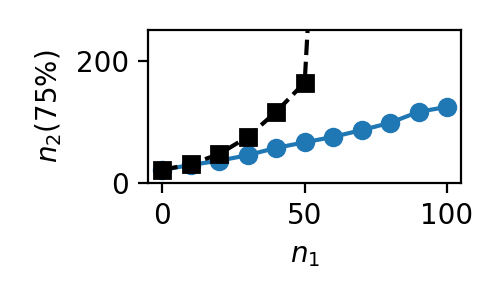

In [348]:
plt.figure(figsize=(2.5,1.5))
plt.plot(nswitch_list, n75_onepath, '-o')
plt.plot(nswitch_list, n75_twopaths, '--sk')
plt.ylim(0, 250)
plt.xlabel('$n_1$')
plt.ylabel('$n_2$(75%)')
#plt.legend(['Single-pathway', 'Two-pathway'])
plt.tight_layout()

# Network becomes resistant to MC perturbations or loss of inputs through training.

For a single repeated pattern, here I'll show that the readout becomes more resistant to MC perturbations or inactivations with more repetitions. I'll also show that the readout activity remains similar when either input is turned off, and that this similarity grows with more repetitions.

In [35]:
def error_pert(nx, ny, n_reps, nz=1, alpha=1, beta=1, w0=1.71, sigma_list=[0],
               reinforce=False, rl_params=(1, 0.1, 100)):
    '''
    Train a network for n_reps repetitions on a single pattern, testing the error rate when 
    perturbations of size sigma are made to MC at each stage.
    
    Parameters
    ----------
    nx, ny : The numbers of units in the two input layers (x~supervised learning, y~Hebbian learning).
        
    n_reps : An array of length p specifying the number of repetitions when training each pattern.
    
    w0 : The initial magnitude of the weight vector undergoing supervised learning.
    
    nz : Number of output units.
    
    alpha : Controls the decay rate of Hebbian weights.
    
    beta : Controls the learning rate for the Hebbian weights.
    
    sigma_list : Each element is the size of perturbation to make to MC during testing.
    
    reinforce : If True, use reinforcement learning rather than supervised learning.
    
    rl_params : parameters (sigma, eta, reps) to use for reinforcement learning (if reinforce=True).
        
    Returns
    -------  
    err_pert : For each training repetition and for each noise amplitude in sigma_list, the population-
        averaged readout error when MC activity is randomly perturbed (a 2D array).
        
    err_les : For each training repetition, the population-averaged readout error when MC input
        is removed (a 1D array).
        
    alignment1 : For each repetition, the alignment between the readout activity in the absence
        of cortical input and the readout activity in the absence of thalamic input.
        
    alignment2 : For each repetition, the alignment between the readout activity in the
        absence of cortical input and the readout activity in the presence of both inputs.
    '''
    n_bar = np.mean(n_reps)
    v0 = beta/alpha**0.5
    
    # If using reinforcement learning, the learning rate and number of repetitions per pattern:
    (sigmaRL, etaRL, repsRL) = rl_params
    
    x = np.random.randn(nx)
    y = np.random.randn(ny)
    z_ = np.random.choice([-1, 1], (nz))
    w = w0*np.random.randn(nz, nx)/nx**0.5
    v = v0*np.random.randn(nz, ny)/ny**0.5
    err_pert = np.zeros((n_reps, len(sigma_list)))
    err_les = np.zeros(n_reps)
    alignment1 = np.zeros(n_reps)
    alignment2 = np.zeros(n_reps)
    
    for ii in range(n_reps):
        m = np.dot(w, x)
        h = np.dot(v, y)
        if reinforce:  # use reinforcement learning
            rbar = 0
            for jj in range(repsRL):
                xi = sigmaRL*np.random.randn(nz)
                r = np.mean(z_*np.sign(m + h + xi))
                dw += etaRL*(r - rbar)*xi*x/nx
                rbar = 0.9*rbar + 0.1*r
        else:  # use supervised learning
            dw = np.outer((z_ - m - h)*theta(1 - (m + h)*z_), x)/nx
        
        # Compute the population-averaged readout error with perturbations:
        for jj, sigma in enumerate(sigma_list):
            m = np.dot(w, x)
            m_pert = np.dot(w, x + sigma*np.random.randn(nx))
            h = np.dot(v, y)
            z = np.sign(m + h)
            z_pert = np.sign(m_pert + h)
            z_h = np.sign(h)
            z_m = np.sign(m)
            err_pert[ii, jj] = 0.25*np.mean((z_pert - z_)**2)
            err_les[ii] = 0.25*np.mean((z_h - z_)**2)
            alignment1[ii] = np.dot(z_h/np.linalg.norm(z_h), z_m/np.linalg.norm(z_m))
            alignment2[ii] = np.dot(z_h/np.linalg.norm(z_h), z/np.linalg.norm(z))
        
        # Update the weights:
        w += dw
        dv = 2**0.5*beta*np.outer(z_, y)/ny
        dv += -alpha*v/ny
        v += dv

    return err_pert, err_les, alignment1, alignment2


In [36]:
n_reps = 10
n_nets = 10
sigma_list = [2, 4]

err_pert = np.zeros((n_nets, n_reps, len(sigma_list)))
err_les = np.zeros((n_nets, n_reps))
alignment1 = np.zeros((n_nets, n_reps))
alignment2 = np.zeros((n_nets, n_reps))

for ii in range(n_nets):
    foo = error_pert(1000, 1000, n_reps, nz=1000, sigma_list=sigma_list)
    err_pert[ii,:,:], err_les[ii,:], alignment1[ii,:], alignment2[ii,:] = foo

<IPython.core.display.Javascript object>


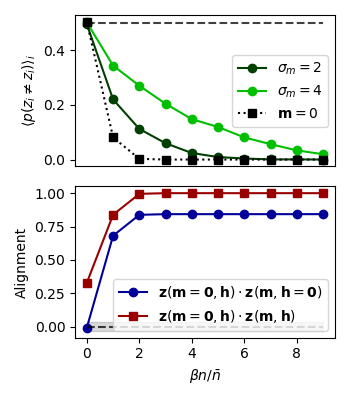

In [37]:
plt.figure(figsize=(3.5,4))

colors = [(0, 0.25, 0), (0, 0.75, 0)]

plt.subplot(211)
for ii in range(len(sigma_list)):
    plt.plot(np.arange(n_reps), np.mean(err_pert[:,:,ii], axis=0), '-o', color=colors[ii])
plt.plot(np.arange(n_reps), np.mean(err_les, axis=0), ':sk')
plt.plot(np.arange(n_reps), 0.5*np.ones(n_reps), '--k', alpha=0.75)
plt.xticks([])    
plt.ylabel('$\langle p(z_i \\neq z_i ) \\rangle_i$')
plt.legend(['$\sigma_m = $'+str(sigma_list[0]), 
            '$\sigma_m = $'+str(sigma_list[1]),
            '$\\mathbf{m} = 0$'])

plt.subplot(212)
plt.plot(np.arange(n_reps), np.mean(alignment1, axis=0), '-o', color=(0,0,0.6))
plt.plot(np.arange(n_reps), np.mean(alignment2, axis=0), '-s', color=(0.6,0,0))
plt.plot(np.arange(n_reps), np.zeros(n_reps), '--k', alpha=0.75)
plt.fill_between(np.arange(n_reps), -np.ones(n_reps)/1000**0.5, np.ones(n_reps)/1000**0.5, color='k', alpha=0.15)
plt.xlabel('$\\beta n / \\bar{n}$')
plt.ylabel('Alignment')
plt.legend(['$\\mathbf{z}(\\mathbf{m}=\\mathbf{0},\\mathbf{h}) \\cdot \\mathbf{z}(\\mathbf{m},\\mathbf{h}=\\mathbf{0})$',
            '$\\mathbf{z}(\\mathbf{m}=\\mathbf{0},\\mathbf{h}) \\cdot \\mathbf{z}(\\mathbf{m},\\mathbf{h})$'],
           loc='lower right')

plt.tight_layout()

# Practiced patterns are recalled better and survive lesion of the tutor input

In [40]:

def errors(nx, ny, p, n_reps, nz=1, alpha=1, beta=1, w0=1.71):
    '''
    Given the number of units in each input population , the number of patterns to be
    learned sequentially, and the number of times to repeat training of each pattern, train a
    single network and return a binary array, where each element is 0 if the corresponding
    pattern was recalled correctly during testing, or 1 if incorrect.
    
    Parameters
    ----------
    nx, ny : The numbers of units in the two input layers (x~supervised learning, y~Hebbian learning).
    
    p : The number of patterns to be trained.
    
    n_reps : An array of length p specifying the number of repetitions when training each pattern.
    
    w0 : The initial magnitude of the weight vector undergoing supervised learning.
    
    nz : Number of output units.
    
    alpha : Controls the decay rate of Hebbian weights.
    
    beta : Controls the learning rate for the Hebbian weights.
            
    Returns
    -------
    err : An array of length p, where each element is 0 if the corresponding pattern is
        recalled correctly after training, or 1 if recalled incorrectly.
        
    err_honly, err_monly : The testing error when the input x or y is removed.
        
    alignment : An array of length p, where each element gives the normalized alignment of
        the inputs from the two pathways for that pattern.
    '''
    n_bar = np.mean(n_reps)
    v0 = beta/alpha**0.5
        
    x = np.random.randn(p, nx)
    y = np.random.randn(p, ny)
    z_ = np.random.choice([-1, 1], (p, nz))
    w = np.zeros((p, nz, nx))
    v = np.zeros((p, nz, ny))
    w[0,:] = w0*np.random.randn(nz, nx)/nx**0.5
    v[0,:] = v0*np.random.randn(nz, ny)/ny**0.5
    dw = np.zeros((p, nz, nx))
    dv = np.zeros((p, nz, ny))
    err = np.zeros(p)
    err_honly = np.zeros(p)
    err_monly = np.zeros(p)
    alignment_train = np.zeros(p)
    alignment_test = np.zeros(p)
    hfrac_train = np.zeros(p)
    hfrac_test = np.zeros(p)
    
    for mu in range(p-1):
        m = np.dot(w[mu,:], x[mu,:])
        h = np.dot(v[mu,:], y[mu,:])
        dw[mu,:,:] = np.outer((z_[mu,:] - m - h)*theta(1 - (m + h)*z_[mu,:]), x[mu,:])/nx
            
        w[mu+1,:,:] = w[mu,:,:] + dw[mu,:,:]
        
        #for ii in range(int(n_reps[mu])):
        dv[mu,:,:] += 2**0.5*beta*n_reps[mu]*np.outer(z_[mu,:], y[mu,:])/(n_bar*ny)   
        dv[mu,:,:] += -alpha*v[mu,:,:]/ny
        v[mu+1,:,:] = v[mu,:,:] + dv[mu,:,:]

        # Compute the alignment with the updated weight vectors:
        m = np.dot(w[mu+1,:,:], x[mu,:])
        h = np.dot(v[mu+1,:,:], y[mu,:])
        #alignment_train[mu+1] = (m/np.linalg.norm(m))*(h/np.linalg.norm(h))
        #alignment_train[mu+1] = np.sign(m/np.linalg.norm(m))*np.sign(h/np.linalg.norm(h))
        alignment_train[mu+1] = np.dot(m/np.linalg.norm(m), h/np.linalg.norm(h))
        hfrac_train[mu+1] = np.dot(h, z_[mu,:])/(abs(np.dot(h, z_[mu,:])) + abs(np.dot(m, z_[mu,:])))

    for nu in range(p-1):
        m = np.dot(w[-1,:,:], x[nu,:])
        h = np.dot(v[-1,:,:], y[nu,:])
        err[nu] = np.mean(theta(-z_[nu,:]*(m + h)))
        err_honly[nu] = np.mean(theta(-z_[nu,:]*h))
        err_monly[nu] = np.mean(theta(-z_[nu,:]*m))
        
        #alignment_test[nu+1] = (m/np.linalg.norm(m))*(h/np.linalg.norm(h))
        #alignment_test[nu+1] = np.sign(m/np.linalg.norm(m))*np.sign(h/np.linalg.norm(h))
        alignment_test[nu+1] = np.dot(m/np.linalg.norm(m), h/np.linalg.norm(h))
        hfrac_test[nu+1] = np.dot(h, z_[nu,:])/(abs(np.dot(h, z_[nu,:])) + abs(np.dot(m, z_[nu,:])))
                    
    return err, err_honly, err_monly, alignment_train, alignment_test, hfrac_train, hfrac_test


def p_inc_sim(n_nets, nx, ny, p, n_reps, nz=1, alpha=1, beta=1, n_bins=100):
    '''
    Train and test multiple networks on sequentially repeated patterns, and return the (binned) 
    probability of incorrect classification across patterns.
        
    Returns
    -------
    p_binned : The binned x-axis points. (Returned if n_bins < p.) 
    
    p_inc_binned : The probabilities (computed over networks) of incorrect classification across
        patterns. (Returned if n_bins < p.)
        
    If n_bins=p, the data is not binned, and the items returned are 
    - mean error across patterns
    - mean error across patterns with m=0
    - mean error across patterns with h=0
    - alignment during training
    - alignment during testing
    - hfrac during training
    - hfrac during testing

    '''

    p_inc = np.zeros((n_nets, p))
    p_inc_honly = np.zeros((n_nets, p))
    p_inc_monly = np.zeros((n_nets, p))
    alignment_train = np.zeros((n_nets, p))
    alignment_test = np.zeros((n_nets, p))
    hfrac_train = np.zeros((n_nets, p))
    hfrac_test = np.zeros((n_nets, p))
    for ii in range(n_nets):
        foo = errors(nx, ny, p, n_reps, nz=nz, alpha=alpha, beta=beta)
        p_inc[ii, :] = foo[0]
        p_inc_honly[ii,:] = foo[1]
        p_inc_monly[ii,:] = foo[2]
        alignment_train[ii, :] = foo[3]
        alignment_test[ii, :] = foo[4]
        hfrac_train[ii,:] = foo[5]
        hfrac_test[ii,:] = foo[6]
        
    p_inc_std = np.std(p_inc, axis=0)/n_nets**0.5
    #alignment_std = np.std(alignment, axis=0)/n_nets**0.5

    # Bin the data:
    if n_bins < p:
        bin_size = p//n_bins
        p_binned = np.arange(p)[::bin_size] + 0.5*bin_size
        p_inc_binned = np.zeros(n_bins)
        p_inc_binned_std = np.zeros(n_bins)
        for ii in range(n_bins):
            p_inc_binned[ii] = np.mean(p_inc[:, ii*bin_size:(ii+1)*bin_size])
            p_inc_binned_std[ii] = np.mean(p_inc_std[ii*bin_size:(ii+1)*bin_size])

        return p_binned, p_inc_binned, alignment_train, alignment_test
    
    else:
        return np.mean(p_inc, axis=0), np.mean(p_inc_honly, axis=0), np.mean(p_inc_monly, axis=0), alignment_train, alignment_test, hfrac_train, hfrac_test
    
    

In [41]:
n_nets = 20
nx, ny = 1000, 1000
p = int(nx+ny)
n_reps = 1*np.ones(p)
n_reps[p//2] = 10

p_inc0, p_inc_honly0, p_inc_monly0, alignment_train0, alignment_test0, hfrac_train0, hfrac_test0 = p_inc_sim(n_nets, 
                                                                                nx, ny, p, n_reps, nz=100, 
                                                                                beta=1, n_bins=p)


<IPython.core.display.Javascript object>


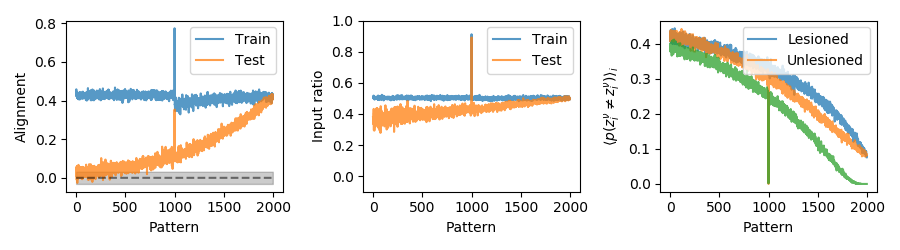

In [43]:

plt.figure(figsize=(9, 2.5))

plt.subplot(131)
plt.plot(np.arange(p-1), np.mean(alignment_train0[:,1:], axis=0), alpha=0.75)
plt.plot(np.arange(p-1), np.mean(alignment_test0[:,1:], axis=0), alpha=0.75)
plt.plot(np.arange(p-1), np.zeros(p-1), '--k', alpha=0.5)
plt.fill_between(np.arange(p-1), -np.ones(p-1)/nx**0.5, np.ones(p-1)/nx**0.5, color='k', alpha=0.2)
plt.xlabel('Pattern')
plt.ylabel('Alignment')
plt.legend(['Train', 'Test'])

plt.subplot(132)
plt.plot(np.arange(p-1), np.mean(hfrac_train0[:,1:], axis=0), alpha=0.75)
plt.plot(np.arange(p-1), np.mean(hfrac_test0[:,1:], axis=0), alpha=0.75)
plt.xlabel('Pattern')
plt.ylabel('Input ratio')
plt.legend(['Train', 'Test'])
plt.ylim(-0.1, 1)

plt.subplot(133)
plt.plot(np.arange(p-1), p_inc_monly0[:-1], alpha=0.75)
plt.plot(np.arange(p-1), p_inc_honly0[:-1], alpha=0.75)
plt.plot(np.arange(p-1), p_inc0[1:], alpha=0.75)
plt.xlabel('Pattern')
plt.ylabel('$\langle p(z_i^\\nu \\neq z_i^\\nu ) \\rangle_i$')
plt.legend(['Lesioned', 'Unlesioned'], loc='upper right')
plt.tight_layout()

In [44]:
# Bin the data:

def bin_data(data, special_point=None, n_bins=50):
    '''
    Bin the data, preserving the special point that was trained multiple times.
    
    Parameters
    ----------
    data : A 1D array of data to bin.
    
    special_point : The index of any point that shouldn't be included in the binning.
    
    n_bins : Number of bins
    '''
    
    p = len(data)
    if special_point is not None:
        sp = data[special_point]
        data[special_point] = 0.5*(data[special_point-1] + data[special_point+1])
    bin_size = p//n_bins
    bins = np.arange(p)[::bin_size] + 0.5*bin_size
    data_binned = np.zeros(n_bins)
    #data_binned_std = np.zeros(n_bins)
    for ii in range(n_bins):
        data_binned[ii] = np.mean(data[ii*bin_size:(ii+1)*bin_size])
        #data_binned_std[ii] = np.mean(data_std[ii*bin_size:(ii+1)*bin_size])

    if special_point is not None:
        data_binned[special_point//bin_size] = sp
    
    return bins, data_binned

In [45]:
bins_, alignment_train_binned = bin_data(np.mean(alignment_train0[:,:], axis=0), special_point=p//2+1)
bins_, alignment_test_binned = bin_data(np.mean(alignment_test0[:,:], axis=0), special_point=p//2+1)
bins_, hfrac_train_binned = bin_data(np.mean(hfrac_train0[:,:], axis=0), special_point=p//2+1)
bins_, hfrac_test_binned = bin_data(np.mean(hfrac_test0[:,:], axis=0), special_point=p//2+1)
bins_, p_inc_honly_binned = bin_data(p_inc_honly0[:], special_point=p//2)
bins_, p_inc_monly_binned = bin_data(p_inc_monly0[:], special_point=p//2)
bins_, p_inc_binned = bin_data(p_inc0[:], special_point=p//2)


<IPython.core.display.Javascript object>


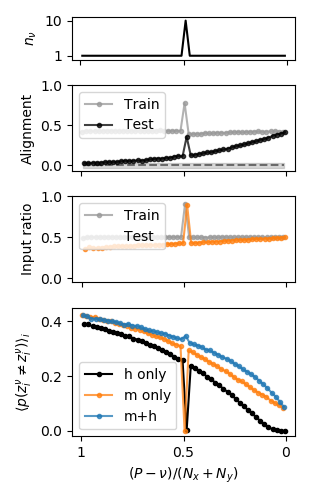

In [46]:
from matplotlib import gridspec

fig = plt.figure(figsize=(3.1, 5)) 
gs = gridspec.GridSpec(4,1 , height_ratios=[1, 2, 2, 3]) 

ax0 = plt.subplot(gs[0])
reps_list = np.ones_like(bins_)
reps_list[len(bins_)//2] = 10
ax0.plot(bins_, reps_list, 'k')
plt.ylim(0, 11)
plt.ylabel('$n_\\nu$')
plt.xticks([0, p/2, p], ['', '', ''])
plt.yticks([1, 10])

ax1 = plt.subplot(gs[1])
ax1.plot(bins_-0.005*p, alignment_train_binned, '.-', color=(0.6,0.6,0.6), alpha=0.75)
ax1.plot(bins_+0.005*p, alignment_test_binned, '.-', color=(0,0,0), alpha=0.75)
ax1.plot(bins_, np.zeros(len(bins_)), '--k', alpha=0.5)
ax1.fill_between(bins_, -np.ones(len(bins_))/1000**0.5, np.ones(len(bins_))/1000**0.5, color='k', alpha=0.15)
plt.ylabel('Alignment')
plt.xticks([0, p/2, p], ['', '', ''])
plt.yticks([0, 0.5, 1])
plt.legend(['Train', 'Test'], loc='upper left')

ax2 = plt.subplot(gs[2])
ax2.plot(bins_-0.005*p, hfrac_train_binned, '.-', color=(0.6,0.6,0.6), alpha=0.75)
ax2.plot([0], [0], '.', ms=0)
ax2.plot(bins_+0.005*p, hfrac_test_binned, '.-', color='tab:orange', alpha=0.75)
plt.ylabel('Input ratio')
plt.xticks([0, p/2, p], ['', '', ''])
plt.yticks([0, 0.5, 1])
plt.legend(['Train', 'Test'])

ax3 = plt.subplot(gs[3])
ax3.plot(bins_+0.005*p, p_inc_binned, '.-k')
ax3.plot(bins_-0.005*p, p_inc_honly_binned, '.-', color='tab:orange', alpha=0.75)
ax3.plot(bins_, p_inc_monly_binned, '.-', color='tab:blue', alpha=0.75)
plt.xlabel('$(P-\\nu)/(N_x + N_y)$')
plt.ylabel('$\langle p(z_i^\\nu \\neq z_i^\\nu ) \\rangle_i$')
plt.xticks([0, p/2, p], [1, 0.5, 0])
plt.legend(['h only', 'm only', 'm+h'])
plt.ylim(-0.02, 0.45)
plt.tight_layout()
